In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from sklearn.cluster import KMeans
from skimage import morphology

In [2]:
# Make plots shown in the notebook rather than a separate window.
%matplotlib inline

In [3]:
# A Slice class that holds all of the information relevant to a slice.
class Slice:
    def __init__(self, name, greys, densities, points, means, voxel_size):
        self.image = name + ".tif"
        self.label = name + "_label.tif"
        self.skel = name + "_skel.tif"
        self.greys = greys
        self.densities = densities
        self.points = points
        self.means = means
        self.voxel_size = voxel_size

In [4]:
# Define the Slice objects for each slice in the calcification directory. The greyscale
# and density values were provided by Dr Kenneth Johnson from the Natural History Museum.
RS0030 = Slice(name="calcification/RS0030_1_yz",
               greys=[49355.9941176471, 44104.6882352941, 39821.1352941176, 32732.8294117647, 26064.9705882353, 21192.1588235294],
               densities=[1.922, 1.773, 1.654, 1.445, 1.266, 1.13],
               points=[[1140, 164], [1320, 164]],
               means=2,
               voxel_size=0.0762383788824081)

RS0116 = Slice(name="calcification/RS0116_0414",
               greys=[42451.8791946309, 38889.6577181208, 35743.7852348993, 30638.1208053691, 25961.932885906, 23126.5771812081],
               densities=[1.922, 1.773, 1.654, 1.445, 1.266, 1.13],
               points=[[1355, 1334], [1474, 1437]],
               means=2,
               voxel_size=0.0956196114420891)

RS0128 = Slice(name="calcification/RS0128_yz_451",
               greys=[36217.5648854962, 32658.786259542, 29625.2824427481, 24806.0534351145, 20296.3053435114, 17492.6106870229],
               densities=[1.922, 1.773, 1.654, 1.445, 1.266, 1.13],
               points=[[630, 346], [648, 244]],
               means=1,
               voxel_size=0.103974558413029)

RS0130 = Slice(name="calcification/RS0130_xz_820",
               greys=[52215.6940298507, 46477.0597014925, 41837.8805970149, 33930.3059701493, 26430.5820895522, 22135.1791044776],
               densities=[1.922, 1.773, 1.654, 1.445, 1.266, 1.13],
               points=[[503, 1455], [607, 1337]],
               means=2,
               voxel_size=0.103730022907257)

In [5]:
# Define which scan will be analysed.
s = RS0030

In [6]:
# Read in image and skeleton
image = cv.imread(s.image, -1)
label = cv.imread(s.skel, -1)

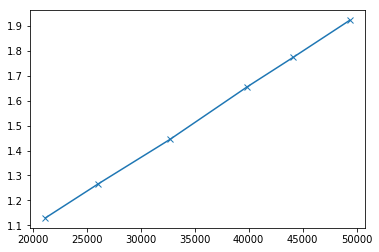

In [7]:
# Plot the calibration density values provided for the scan.
plt.plot(s.greys, s.densities, marker="x")

In [8]:
# Define a simple quadratic equation for the curve_fit() method to use.
def quad(x, a, b, c):
    return a * (x ** 2) + (b * x) + c

# Use the scipy curve_fit() method to fit the quadratic function to the data.
params, params_covariance = optimize.curve_fit(quad, s.greys, s.densities)

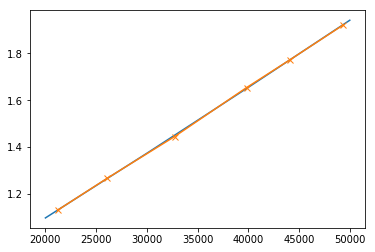

In [9]:
# Plot the fit curve against the original data.
fake = [50000, 40000, 30000, 20000]
guesses = [quad(fake[i], params[0], params[1], params[2]) for i in range(len(fake))]

plt.plot(fake, guesses)
plt.plot(s.greys, s.densities, marker="x")

(array([236396.,  78944.,  33122.,   9421.,  12289.,   7698.,   2604.,
          4068.,   5622.,   5698.,  20018.,  17321.,  55029.,  75210.,
         40105.,  72093.,  30283.,  48007.,  34277.,  12975.,  19692.,
          6915.,   9538.,   3147.,   4225.,   1270.,   1619.,    435.,
           547.,    247.]),
 array([0.5599891 , 0.62124868, 0.68250826, 0.74376784, 0.80502741,
        0.86628699, 0.92754657, 0.98880615, 1.05006573, 1.11132531,
        1.17258489, 1.23384446, 1.29510404, 1.35636362, 1.4176232 ,
        1.47888278, 1.54014236, 1.60140194, 1.66266151, 1.72392109,
        1.78518067, 1.84644025, 1.90769983, 1.96895941, 2.03021899,
        2.09147856, 2.15273814, 2.21399772, 2.2752573 , 2.33651688,
        2.39777646]),
 <a list of 30 Patch objects>)

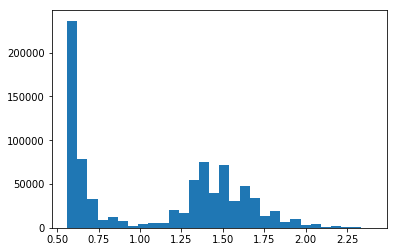

In [10]:
# Calculate densities of all pixels in the image
image_densities = np.zeros(image.shape)

for y in range(image.shape[0]):
    for x in range(image.shape[1]):
        image_densities[y, x] = quad(image[y, x], *params)

plt.hist(image_densities.flatten(), bins=30)

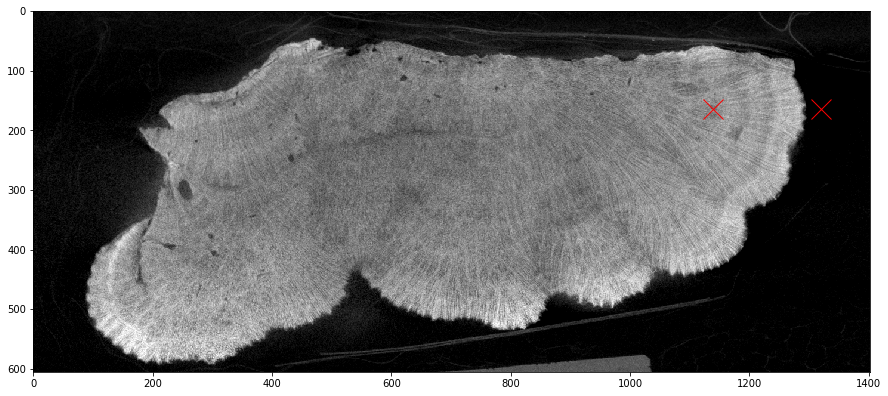

In [11]:
fig, ax = plt.subplots(figsize=(15,15))

a, b = s.points

# Visualise the points chosen
ax.imshow(image, cmap="gray")
ax.plot(a[0], a[1], marker="x", markersize=20, color="red")
ax.plot(b[0], b[1], marker="x", markersize=20, color="red")

plt.show()

In [12]:
# Returns the point half way between the two points provided
def center_point(x, y):
    return [(x[0] + y[0]) / 2, (x[1] + y[1]) / 2]

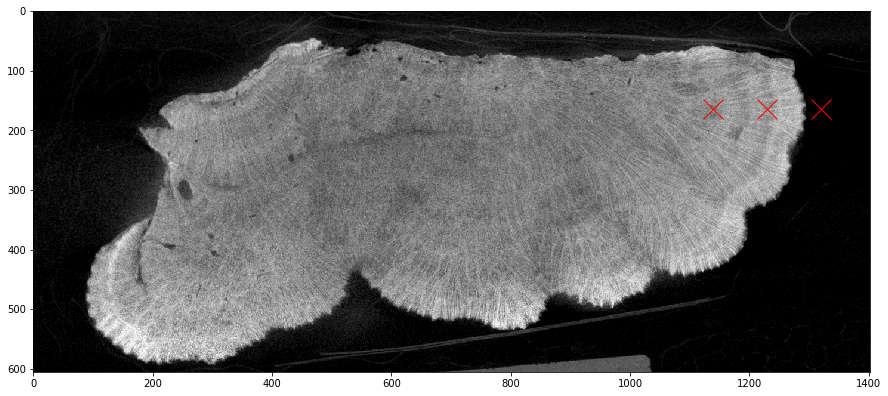

In [13]:
fig, ax = plt.subplots(figsize=(15,15))

# Find the center point
c = center_point(a, b)

# Visualise the center point
ax.imshow(image, cmap="gray")
ax.plot(a[0], a[1], marker="x", markersize=20, color="red")
ax.plot(b[0], b[1], marker="x", markersize=20, color="red")
ax.plot(c[0], c[1], marker="x", markersize=20, color="red")

plt.show()

In [14]:
# Find the vector from the firs point to the second.
vector = [b[1] - a[1], b[0] - a[0]]

In [15]:
# Find angle between the line drawn by the two points and the x axis
angle_r = np.arctan2(*vector)
angle_d = np.degrees(angle_r)

print(angle_d)

0.0


In [16]:
# Rotate a point around an origin point by a given angle
def rotate(p, origin=(0, 0), angle=0):
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle),  np.cos(angle)]])
    o = np.atleast_2d(origin)
    p = np.atleast_2d(p)
    return np.squeeze((R @ (p.T-o.T) + o.T).T)

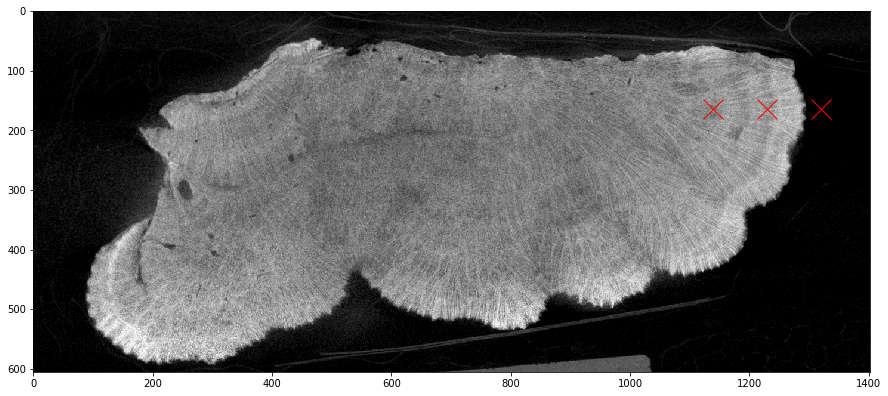

In [17]:
# Rotate the image around the central point
matrix = cv.getRotationMatrix2D(center=tuple(c), angle=angle_d, scale=1)
rotated_image = cv.warpAffine(src=image, M=matrix, dsize=image.shape[::-1])
rotated_label = cv.warpAffine(src=label, M=matrix, dsize=label.shape[::-1])

# Rotate the two points too.
a_r, b_r = rotate([a, b], origin=c, angle=-angle_r)

fig, ax = plt.subplots(figsize=(15,15))

# Visualise the rotated image and points
ax.imshow(rotated_image, cmap="gray")
ax.plot(a_r[0], a_r[1], marker="x", markersize=20, color="red")
ax.plot(b_r[0], b_r[1], marker="x", markersize=20, color="red")
ax.plot(  c[0],   c[1], marker="x", markersize=20, color="red")

plt.show()

In [18]:
# Print the newly rotated points.
print(a_r, b_r, c)

[1140.  164.] [1320.  164.] [1230.0, 164.0]


In [19]:
# Define how wide the rectangular area should be.
box_width = 20

# Crop the image and the label to the rectangular area.
cropped_image = rotated_image[int(c[1] - box_width):int(c[1] + box_width) :, int(a_r[0]):int(b_r[0])]
cropped_label = rotated_label[int(c[1] - box_width):int(c[1] + box_width) :, int(a_r[0]):int(b_r[0])]
_, cropped_label = cv.threshold(cropped_label, 50, 255, cv.THRESH_BINARY)

# Find any very small boundaries that should be removed.
processed = morphology.remove_small_objects(cropped_label.astype(bool), min_size=6, connectivity=2).astype(int)
# black out pixels
cropped_label[np.where(processed == 0)] = 0

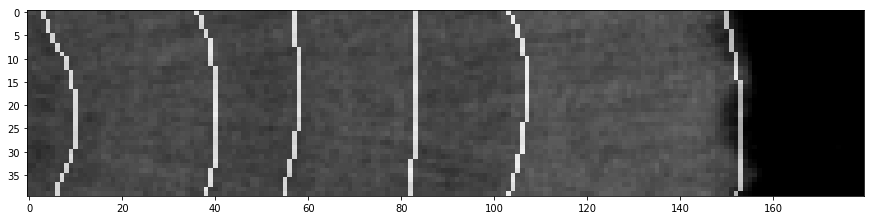

In [20]:
fig, ax = plt.subplots(figsize=(15,15))

# Visualise the rectangular area.
ax.imshow(cropped_image, cmap="gray")
ax.imshow(cropped_label, cmap="gray", alpha=0.6)

plt.show()

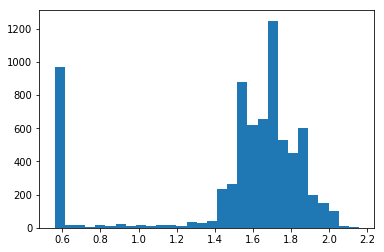

In [21]:
# Visualise the histogram of the density values present in the rectangular area.
c_image_densities = np.zeros(cropped_image.shape)

for y in range(cropped_image.shape[0]):
    for x in range(cropped_image.shape[1]):
        c_image_densities[y, x] = quad(cropped_image[y, x], *params)

heights, densities, _ = plt.hist(c_image_densities.flatten(), bins=30)

In [22]:
# Use K-means to find the mean density of the coral. This will be the higher mean since
# the other mean corresponds to the area outside of the coral which should be air
# so should be less dense.
kmeans = KMeans(n_clusters=s.means, random_state=0).fit(c_image_densities.flatten().reshape(-1, 1))
mean_density = np.max(kmeans.cluster_centers_)

print(mean_density)

1.6818925491943557


In [23]:
# Finds the average distance between two boundaries.
def euclidean(shape, boundaries):
    euclidean = np.zeros(shape)
    for i in range(len(boundaries) - 1):
        for j in boundaries[i]:
            euclidean[j] = np.inf
            for k in boundaries[i + 1]:
                distance = np.linalg.norm(np.array(j) - np.array(k))
                euclidean[j] = min(euclidean[j], distance)
    return euclidean

In [24]:
# Use the OpenCV connectedComponents() method to label the individual boundaries.
num_labels, labels_image = cv.connectedComponents(cropped_label)

for i in range(num_labels):
    if np.sum(labels_image == i) < 10:
        labels_image[labels_image == i] = 0
        cropped_label[labels_image == i] = 0

In [25]:
labels = []

# Sort the boundaries with the growth surface first.
for x in range(labels_image.shape[1]-1, -1, -1):
    for y in range(labels_image.shape[0]):
        label = labels_image[y, x]
        if cropped_label[y, x] != 0 and label not in labels:
            labels.append(label)

print(labels)

boundaries = {}

for i in range(len(labels)):
    boundaries[i] = []

# Save the boundary pixels into a boundaries dictionary.
for y in range(labels_image.shape[0]):
    for x in range(labels_image.shape[1]):
        label = labels_image[y, x]
        if label in labels:
            index = labels.index(label)
            boundaries[index].append((y, x))
        
euclidean_image = euclidean(cropped_label.shape, boundaries)

[6, 5, 4, 3, 2, 1]


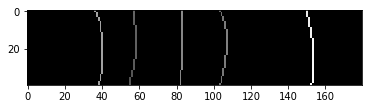

In [26]:
plt.imshow(euclidean_image, cmap='gray')

In [27]:
# Find the average distance in pixels between each of the boundaries.
averages = np.zeros(len(labels) - 1)
for i in range(len(labels) - 1):
    for j in boundaries[i]:
        averages[i] += + euclidean_image[j]
    averages[i] /= len(boundaries[i])
print(averages)

[45.71124058 22.82804905 25.23896219 17.49849828 30.02915077]


In [28]:
# Calculate the linear extension rate and the calcification rate.
linear_extension_mm = np.mean(averages) * 2 * s.voxel_size
calcification = (linear_extension_mm / 10) * mean_density

print(f"Density: {mean_density:.2f} g cm^(-3)")
print(f"Linear extension rate: {linear_extension_mm:.2f} mm^ y^(-1)")
print(f"Calcification rate: {calcification:.2f} g cm^(-2) y^(-1)")

Density: 1.68 g cm^(-3)
Linear extension rate: 4.31 mm^ y^(-1)
Calcification rate: 0.72 g cm^(-2) y^(-1)
